In [7]:
# 
# Author: Tianran Zhang
# Contact: tianran.zhang@kcl.ac.uk 
# Date: 2017-04-04 19:24:35
# Last Modified by:  Tianran Zhang 
# Last Modified time: 2020-08-27 17:07:24

                                  #########       
                                 ##       ###     
                        #########      ######     
                    ####             ##           
                  ###                 ##          
               ###              ########          
            ####    #######    ##                 
       #####   #####     ##  ###                  
       ########          ########    
        
%matplotlib inline

import os
import sys
import glob
import datetime
import numpy as np
from netCDF4 import Dataset,num2date, date2num
import matplotlib.pyplot as plt
import cartopy


dir_data     = 'C:/Users/Tianr/Dropbox/Research/VIIRS/Paper_FireEmission/productCheck/public/'
dir_external = 'C:/Users/Tianr/Dropbox/Research/VIIRS/Paper_FireEmission/productCheck/external_input/'
dir_fig      = os.getcwd()

dir_shp      = dir_external
ADD_SHAPEFILE      = True

In [8]:
latlim = [27,41]
lonlim = [111,123]
degree = 0.1
agrdegree = 0.01
latlen = int((latlim[1]-latlim[0])/degree)
lonlen = int((lonlim[1]-lonlim[0])/degree)
latlist = np.arange(latlim[0],latlim[1],degree)
lonlist = np.arange(lonlim[0],lonlim[1],degree)

fontsize = 15
dpi      = 150

In [9]:
def readFRE(nc_file_name):
    dataset = Dataset('%s'%(nc_file_name),'r') 
    FRE = dataset.variables['FRE'][:,:,:]
    FRE[np.where(np.isinf(FRE))]=0.0
    FRE[np.where(np.isnan(FRE))]=0.0
    latitude = dataset.variables['lat'][:]
    longitude = dataset.variables['lon'][:]
    times = dataset.variables['time']
    FREdates = num2date(times[:], units=times.units,calendar=times.calendar)
    dataset.close() 
    return FRE,FREdates,latitude,longitude

def read_month_harvestmap(read_month):
    harvest_map_path = os.path.join(dir_external,'MIRCA2000_EChina_CropRotationMap_2000_01degree.nc')
    dataset = Dataset(harvest_map_path,'r') 
    month_name = str(read_month)[4:]
    ###condition for winter season, see paper Section 5.1
    if ((month_name == '12') or (month_name =='01')or (month_name =='11')):
        month_name = '10'
    harvestArr = dataset.variables[month_name][:,:]
    dataset.close()    
    wheatArr = np.zeros(harvestArr.shape)
    cornArr  = np.zeros(harvestArr.shape)
    riceArr  = np.zeros(harvestArr.shape)
    wheatArr[harvestArr==1] = 1
    cornArr[harvestArr==2]  = 1
    riceArr[harvestArr==3]  = 1
    return wheatArr,cornArr,riceArr


In [10]:
seasonlist = [[5,6],
             [9,10],
             [11,12]]
pltArr = np.zeros((12,latlen,lonlen))
for ind,year in enumerate(np.arange(2012,2016)):
    for jnd in np.arange(3):
        ###read summer burning season data
        nc_name_0   = os.path.join(dir_data,'VIIRS_HIM8_EChina_AgriEmission_%04d%02d_ver0.nc'%(year,seasonlist[jnd][0]))
        FRE0,_,_,_ =  readFRE(nc_name_0)
        nc_name_1   = os.path.join(dir_data,'VIIRS_HIM8_EChina_AgriEmission_%04d%02d_ver0.nc'%(year,seasonlist[jnd][1]))
        FRE1,_,_,_ =  readFRE(nc_name_1)
        FREplot = np.sum(FRE0,axis=0) + np.sum(FRE1,axis=0)
        pltArr[jnd*4+ind,:,:] = FREplot
####check data
print ('--------------check data---------------------')
print (np.sum(pltArr,axis=(1,2)).astype(int))

C:\Users\tianr\AppData\Local\conda\conda\envs\geoprocess\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  if __name__ == '__main__':


--------------check data---------------------
[485 361 408 161 105 173 100  95  44 119  85  26]


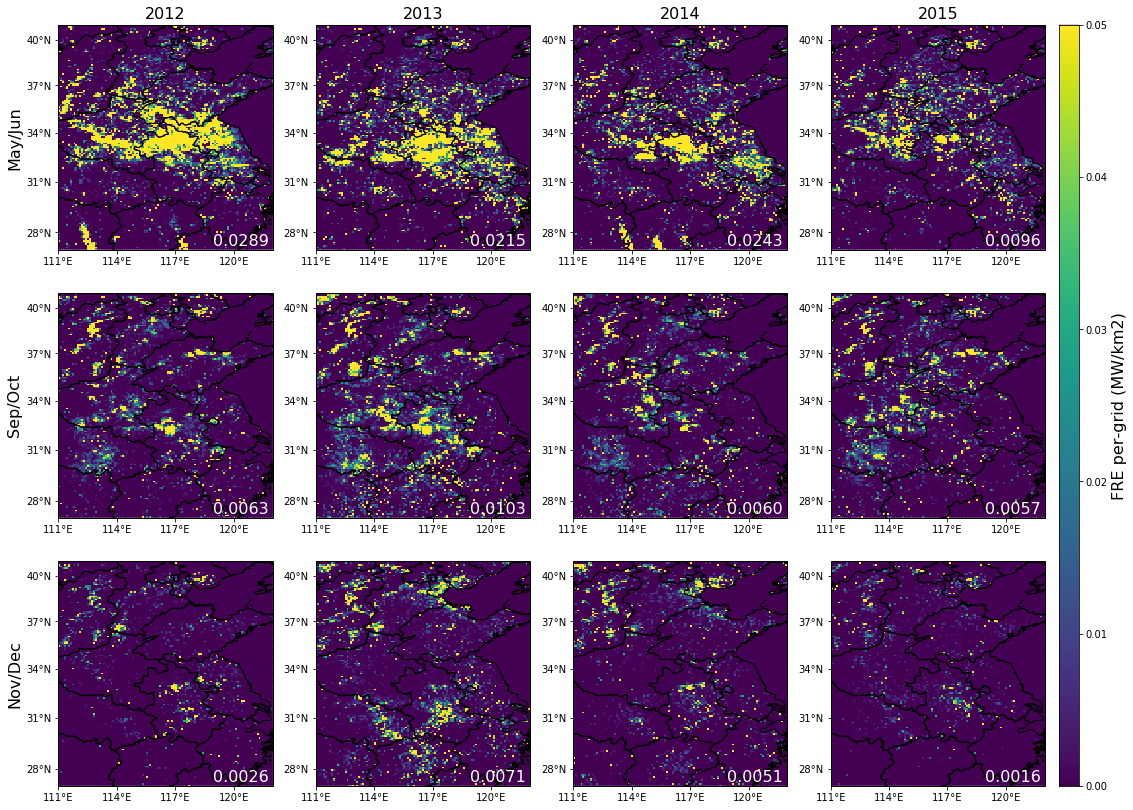

In [13]:
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy.io.shapereader as shpreader

projectionP = ccrs.PlateCarree()
projectionL = ccrs.LambertCylindrical()
axes_class = (GeoAxes,
                  dict(map_projection=projectionL))

lons,lats = np.meshgrid(lonlist,latlist)
vmin = 0.0
vmax = 0.05
fontsize = 16
xS = 0.72
yS = 0.02
color = 'w'

fig = plt.figure(figsize=(20,14))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(3, 4),
                    axes_pad=0.6,
                    cbar_location='right',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    label_mode='')  # note the empty label_mode

for i, ax in enumerate(axgr):
    
        ax.set_xticks(np.arange(lonlim[0],lonlim[1], 3), crs=projectionP)
        ax.set_yticks(np.arange(28,45, 3), crs=projectionP)
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.set_extent([lonlim[0],lonlim[1]-1, latlim[0],latlim[1]])
        
        if ADD_SHAPEFILE:
            reader = shpreader.Reader('%s/ChinaProvince.shp'%(dir_shp))
            ax.add_geometries(reader.geometries(), projectionP, facecolor='None',edgecolor='k', linewidth=1)
        
        cs=ax.pcolormesh(lons, lats, pltArr[i, ...],vmin=vmin,vmax=vmax,transform=projectionP
#                          cmap='hot_r'
                        )
        
        ii = int(i/4)
        jj = int(i%4)
        if ii == 0:
            ax.set_title(2012+jj,fontsize = fontsize)
        if jj == 0:
            if ii == 0:
                ax.set_ylabel('May/Jun',fontsize = fontsize)  
            elif ii ==1:
                ax.set_ylabel('Sep/Oct',fontsize = fontsize)
            else:
                ax.set_ylabel('Nov/Dec',fontsize = fontsize)
        mFRE = np.mean(pltArr[i, ...])
        ax.annotate("%4.4f"%(mFRE), xy=(xS,yS),xycoords='axes fraction',
                 fontsize=fontsize,color=color)

cbar = axgr.cbar_axes[0].colorbar(cs)
cbar.ax.set_ylabel("FRE per-grid (MW/km2)",fontsize=fontsize)

fig.savefig(os.path.join(dir_fig,'Figure6.png'))
plt.show()